In [1]:
!pip install lightning

In [2]:
OBJECTS_ROOT = r"/home/shared/datasets/pollen_dataset_2024_08_14_objects_clean"

In [3]:
import os
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
from PIL import Image, ImageOps

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as TVF
from torchvision import models
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

In [4]:
def pad2size(image, size=(448, 448)):
    return ImageOps.pad(image, size)

def scale2factor(image, factor=0.5):
    return ImageOps.scale(image, factor)

class PollenTripletDataset(Dataset):
    def __init__(self, dataset, classes_map, 
                 static_transform=None, 
                 random_transform=None):
        self.known_classes_numbers = list(classes_map.values())
        self.classes_map = classes_map
        self.transform = random_transform
        self._all_samples = []
        self._class_to_indices = {i: [] for i,c in enumerate(self.known_classes_numbers)}
        
        total_samples = 0
        for idx, sample in enumerate(tqdm(dataset)):
            img = Image.open(sample["image"])
            c_number = classes_map[sample["label"]]
            if static_transform is not None:
                img = static_transform(img)
            self._all_samples.append((c_number, img))
            self._class_to_indices[c_number].append(total_samples)
            total_samples += 1
        print(f"Total samples: {total_samples}")

    def __len__(self):
        return len(self._all_samples)

    def __getitem__(self, idx):
        label, anchor = self._all_samples[idx]
        
        positive_idx = random.choice(self._class_to_indices[label])
        positive = self._all_samples[positive_idx][1]
        
        neg_classes = [c for c in self.known_classes_numbers if (c != label and c != 0)]
        negative_class = random.choice(neg_classes)
        negative_idx = random.choice(self._class_to_indices[negative_class])
        negative_label, negative = self._all_samples[negative_idx]
        
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        
        anchor = torch.as_tensor(anchor) if not isinstance(anchor, torch.Tensor) else anchor
        positive = torch.as_tensor(positive) if not isinstance(positive, torch.Tensor) else positive
        negative = torch.as_tensor(negative) if not isinstance(negative, torch.Tensor) else negative

        label = torch.as_tensor(label) if not isinstance(label, torch.Tensor) else label
        negative_label = torch.as_tensor(negative_label) if not isinstance(negative_label, torch.Tensor) else negative_label

        return anchor, positive, negative, F.one_hot(label, num_classes=len(self.classes_map)).type(torch.FloatTensor), F.one_hot(negative_label, num_classes=len(self.classes_map)).type(torch.FloatTensor)

In [5]:
def load_dataset(data_dir: str) -> tuple:
    """ Returns PollenTripletDataset tuple: (dataset_train, dataset_val, dataset_test) """
    all_classes = os.listdir(data_dir)

    print(f"All known classes: {all_classes}")
    train_classes, pseudo_unknown_classes = train_test_split(all_classes, test_size=0.1, random_state=42)
    # Urtica (крапива), Gramineae (злаки)
    
    classes_map = {value:(key+1) for key, value in enumerate(train_classes)}
    classes_map["Unknown"] = 0

    # train_classes, val_classes = train_test_split(train_classes, test_size=0.2, random_state=42)
    trainval_dataset = []
    test_dataset = []
    for c in tqdm(train_classes):
        if not os.path.isdir(os.path.join(data_dir, c)):
            continue
        images = glob(os.path.join(data_dir, c, "*.png"))
        names = [os.path.split(n)[1].rsplit("_", maxsplit=1)[0] for n in images]
        names.sort()
        names = list(set(names))
        trainval_pictures, test_pictures = train_test_split(names, test_size=0.2, random_state=42)
        for pic in trainval_pictures:
            trainval_img =  glob(os.path.join(data_dir, c, f"{pic}*.png"))
            trainval_dataset.extend([{"label": c, "image": im} for im in trainval_img])
        for pic in test_pictures:
            test_img =  glob(os.path.join(data_dir, c, f"{pic}*.png"))
            test_dataset.extend([{"label": c, "image": im} for im in test_img])
    
    print(f"Known train classes: {train_classes}")
    print(f"Pseudo unknown classes (for test): {pseudo_unknown_classes}")

    train_dataset, val_dataset = train_test_split(trainval_dataset, test_size=0.2, random_state=42)
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
    
    static_transforms = v2.Compose([
        v2.Lambda(scale2factor),
        v2.Lambda(pad2size),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    
    
    print("\nLoad Train Dataset")
    dataset_train = PollenTripletDataset(train_dataset, classes_map, static_transform=static_transforms)
    print("\nLoad Validation Dataset")
    dataset_val = PollenTripletDataset(val_dataset, classes_map, static_transform=static_transforms)
    print("\nLoad Test Dataset")
    dataset_test = PollenTripletDataset(test_dataset, classes_map, static_transform=static_transforms)
    return classes_map, dataset_train, dataset_val, dataset_test

classes_map, dataset_train, dataset_val, dataset_test = load_dataset(OBJECTS_ROOT)

label_map = {v: k for k, v in classes_map.items()}

All known classes: ['Alnus', 'Betula', 'Corylus', 'Acer', 'Chenopodiaceae', 'Pinus', 'Poaceae', 'Apiaceae', 'Rumex', 'Salix', 'Populus tremula', 'Urtica', 'Artemisia', 'Picea', 'Tilia', 'Plantago', 'Quercus', 'Fraxinus']


  0%|          | 0/16 [00:00<?, ?it/s]

Known train classes: ['Rumex', 'Pinus', 'Acer', 'Picea', 'Quercus', 'Plantago', 'Urtica', 'Corylus', 'Salix', 'Fraxinus', 'Chenopodiaceae', 'Artemisia', 'Apiaceae', 'Populus tremula', 'Tilia', 'Poaceae']
Pseudo unknown classes (for test): ['Alnus', 'Betula']
Train dataset size: 1478
Validation dataset size: 370
Test dataset size: 445

Load Train Dataset


  0%|          | 0/1478 [00:00<?, ?it/s]

Total samples: 1478

Load Validation Dataset


  0%|          | 0/370 [00:00<?, ?it/s]

Total samples: 370

Load Test Dataset


  0%|          | 0/445 [00:00<?, ?it/s]

Total samples: 445


In [6]:
def plot(imgs, row_title=None, labels=None, **imshow_kwargs):
    if labels != None:
        ax_title = True
    else:
        ax_title = False
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = TVF.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = TVF.to_dtype(img, torch.uint8, scale=True)
            black_pixels = (img != 0).all(dim=0)
            img[:, ~black_pixels] = 255
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            if ax_title:
                ax.set_title(labels[col_idx])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [7]:
class OpenSetClassificationModel(nn.Module):
    def __init__(self, backbone, embedding_size, n_classes):
        super().__init__()
        if backbone == "resnet18":
            self.model = models.resnet18(weights='DEFAULT')
            num_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
        elif backbone == "resnet34":
            self.model = models.resnet34(weights='DEFAULT')
            num_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
        elif backbone == "resnet50":
            self.model = models.resnet50(weights='DEFAULT')
            num_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
        elif backbone == "resnet101":
            self.model = models.resnet101(weights='DEFAULT')
            num_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
        elif backbone == "resnet152":
            self.model = models.resnet152(weights='DEFAULT')
            num_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
        elif backbone == "efficientnet_v2":
            self.model = models.efficientnet_v2_s(weights='DEFAULT')
            num_features = self.model.classifier[1].in_features
            self.model.classifier = nn.Identity()
        elif backbone == "inception_v3":
            self.model = models.inception_v3(weights='DEFAULT', aux_logits=False)
            num_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
        elif backbone == "vit":
            self.model = models.vit_b_16(weights='DEFAULT')
            num_features = self.model.heads.head.in_features
            self.model.heads.head = nn.Identity()
        elif backbone == "swin_transformer":
            self.model = models.swin_t(weights='DEFAULT')
            num_features = self.model.head.in_features
            self.model.head = nn.Identity()
        else:
            raise ValueError("Unsupported backbone")

        self.embeddings = nn.Linear(num_features, embedding_size)
        self.classifier = nn.Linear(embedding_size, n_classes)

    def forward(self, x):
        x = self.model(x)
        x = self.embeddings(x)
        e = nn.functional.normalize(x) # L2 normalization to put all values on a sphere
        c = self.classifier(e)
        return c, e

In [8]:
class PollenOSCEmbeddingsModule(L.LightningModule):
    def __init__(self,
                 n_classes,
                 embedding_size,
                 optim_lr=0.001,
                 optim_betas=(0.9, 0.999),
                 optim_eps=1e-08,
                 optim_weight_decay=0,
                 check_val=20,
                 freeze_epochs=10
                 ):
        super().__init__()
        # call this to save (arguments) to the checkpoint
        self.save_hyperparameters()

        self.triplet_loss_function = nn.TripletMarginWithDistanceLoss(
                    distance_function=lambda x, y: 1.0 - nn.functional.cosine_similarity(x, y), 
                    margin=1.0)
        self.celoss = nn.CrossEntropyLoss()

        self.best_score = 1
        self.best_val_epoch = -1

        self.model = OpenSetClassificationModel("resnet18", embedding_size, n_classes)

        self.train_step_outputs = []
        self.val_step_outputs = []
        self.train_losses = []
        self.val_losses = []

        # self.freeze_backbone()

    def freeze_backbone(self):
        for param in self.model.model.parameters():
            param.requires_grad = False
        for param in self.model.embeddings.parameters():
            param.requires_grad = True
        for param in self.model.classifier.parameters():
            param.requires_grad = True

    def unfreeze_all(self):
        for param in self.model.parameters():
            param.requires_grad = True

    def on_train_epoch_start(self):
        pass
        # if self.current_epoch == self.hparams.freeze_epochs:
        #     self.unfreeze_all()

    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        anchor, positive, negative, label, neg_label = batch

        anchor_out, anchor_emb = self.model(anchor)
        positive_out, positive_emb = self.model(positive)
        negative_out, negative_emb  = self.model(negative)
        
        triplet_loss = self.triplet_loss_function(anchor_out, positive_out, negative_out)
        celoss = self.celoss(anchor_out, label) + self.celoss(positive_out, label) + self.celoss(negative_out, neg_label)
        loss = triplet_loss + celoss
        pred = {"train_loss": loss, "train_number": len(anchor_out)}
        self.train_step_outputs.append(pred)
        return loss

    def on_train_epoch_end(self):
        outputs = self.train_step_outputs
        train_loss, num_items = 0, 0
        for output in outputs:
            train_loss += output["train_loss"].sum().item()
            num_items += output["train_number"]

        mean_train_loss = torch.tensor(train_loss / num_items)
        self.log("train_loss", mean_train_loss)
        self.train_losses.append(mean_train_loss.item())
        self.train_step_outputs.clear()  # free memory

    def validation_step(self, batch, batch_idx):
        anchor, positive, negative, label, neg_label = batch
        anchor_out, anchor_emb = self.model(anchor)
        positive_out, positive_emb = self.model(positive)
        negative_out, negative_emb  = self.model(negative)
        
        triplet_loss = self.triplet_loss_function(anchor_out, positive_out, negative_out)
        celoss = self.celoss(anchor_out, label) + self.celoss(positive_out, label) + self.celoss(negative_out, neg_label)
        loss = triplet_loss + celoss
        pred = {"val_loss": loss, "val_number": len(anchor_out)}
        self.val_step_outputs.append(pred)

    def on_validation_epoch_end(self):
        outputs = self.val_step_outputs
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]

        mean_val_loss = torch.tensor(val_loss / num_items)
        self.val_losses.append(mean_val_loss.item())
        self.val_step_outputs.clear()  # free memory
        
        tensorboard_logs = {
            "val_loss": mean_val_loss
        }
        self.log("val_loss", mean_val_loss)

        if mean_val_loss < self.best_score:
            self.best_score = mean_val_loss
            self.best_val_epoch = self.current_epoch

    def configure_optimizers(self):
        initial_lr = self.hparams.optim_lr * 10
        self.optimizer = torch.optim.Adam(
            [
                {'params': self.model.model.parameters(), 'lr': 1e-5},
                {'params': self.model.embeddings.parameters(), 'lr': 1e-2},
                {'params': self.model.classifier.parameters(), 'lr': 1e-2},
            ],
            lr=initial_lr,
            betas=self.hparams.optim_betas,
            eps=self.hparams.optim_eps,
            weight_decay=self.hparams.optim_weight_decay
        )
        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": ReduceLROnPlateau(self.optimizer, factor=0.1, patience=10),
                "frequency": self.hparams.check_val,
                "monitor": "val_loss",
                "interval": "epoch",
            }
        }

    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot([i for i in range(len(self.train_losses))], self.train_losses, label='Train Loss')
        plt.plot([i * self.hparams.check_val for i in range(len(self.val_losses))], self.val_losses, label='Validation Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses')
        plt.legend()
        plt.show()

In [48]:
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size= 32,
    shuffle= True,
    num_workers= 6
)
val_loader = torch.utils.data.DataLoader(
    dataset_val, 
    batch_size= 4,
    shuffle= False,
    num_workers= 6
)
test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size= 6,
    shuffle= False,
    num_workers= 6
)

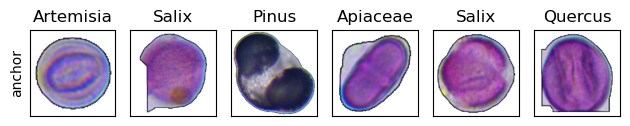

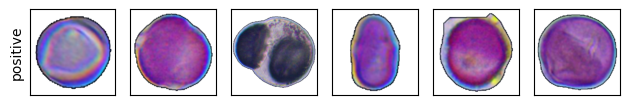

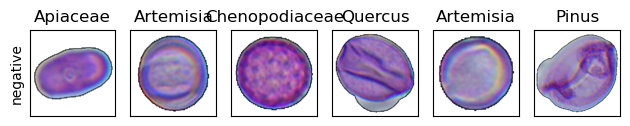

In [10]:
for anchor, positive, negative, label, negative_label in train_loader:
    plot(anchor[:6], row_title=["anchor"], labels=[label_map[torch.argmax(l).item()] for l in label[:6]])
    plot(positive[:6], row_title=["positive"])
    plot(negative[:6], row_title=["negative"], labels=[label_map[torch.argmax(l).item()] for l in negative_label[:6]])
    break

In [11]:
model = PollenOSCEmbeddingsModule(n_classes=len(label_map), embedding_size=128, check_val=3, freeze_epochs=30) # Do not train backbone

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
model = model.to(device)
# summary(model.model, input_size=(3, 448, 448))

In [14]:
checkpoint_callback = ModelCheckpoint(
    filename='checkpoint-{epoch:02d}-{val_loss:.2f}',
    # auto_insert_metric_name=False,
    dirpath="./history",
    monitor='val_loss',
    mode='min')
lr_logger = LearningRateMonitor()
logger = CSVLogger("logs", name="triplet_cos_2")

In [15]:
trainer = L.Trainer(logger=logger,
                    log_every_n_steps=2,  # Increase, if epoch size is large
                    callbacks=[checkpoint_callback, lr_logger],
                    precision="16-mixed",
                    check_val_every_n_epoch=model.hparams.check_val,
                    max_epochs=30,
                    accumulate_grad_batches=2,
                    )

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model, 
            train_dataloaders=train_loader, 
            val_dataloaders=val_loader,     
)

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/jovyan/Pollen-Analyzer/Classification/history exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                          | Params | Mode 
--------------------------------------------------------------------------------
0 | triplet_loss_function | TripletMarginWithDistanceLoss | 0      | train
1 | celoss                | CrossEntropyLoss              | 0      | train
2 | model                 | OpenSetClassificationModel    | 11.2 M | train
--------------------------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.977    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


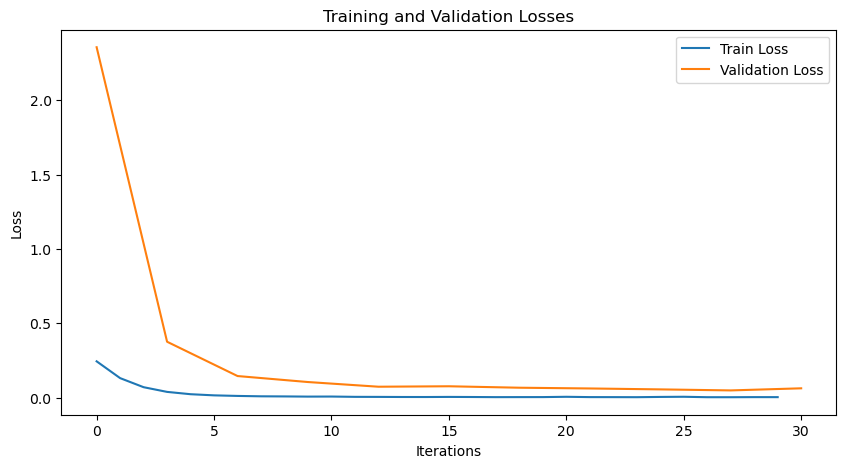

In [17]:
model.plot_losses()

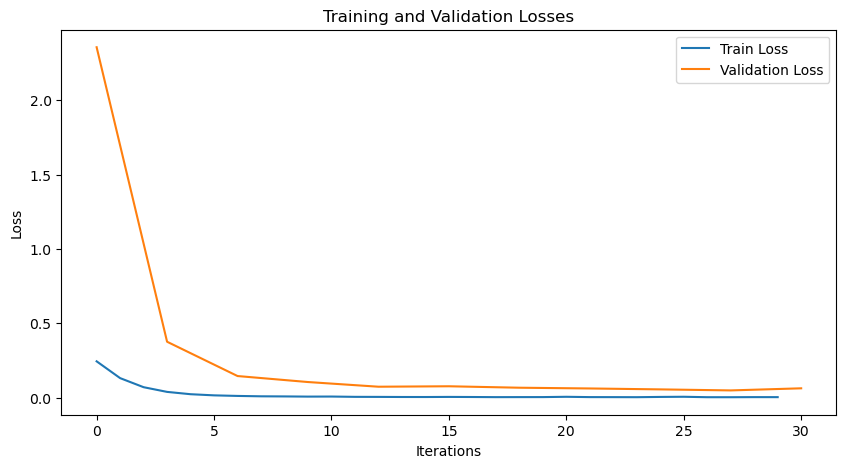

In [18]:
plt.figure(figsize=(10, 5))
plt.plot([i for i in range(len(model.train_losses))], model.train_losses, label='Train Loss')
plt.plot([i * model.hparams.check_val for i in range(len(model.val_losses))], model.val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [19]:
def add_class_markings(ax, class_boundaries, labels):
    tick_locs = [(class_boundaries[i] + class_boundaries[i+1] - 1) / 2 for i in range(len(class_boundaries)-1)]
    ax.set_xticks(tick_locs)
    ax.set_yticks(tick_locs)
    ax.set_xticklabels([labels[int(loc)] for loc in tick_locs])
    ax.set_yticklabels([labels[int(loc)] for loc in tick_locs])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for boundary in class_boundaries[1:-1]:
        ax.axhline(y=boundary-1, color='k', linestyle='-', linewidth=1)
        ax.axvline(x=boundary-1, color='k', linestyle='-', linewidth=1)

In [20]:
from matplotlib.colors import PowerNorm

def plot_matrix(embeddings_lists: list, labels_lists: list, subtitle: str=None, axes_class_markings: bool=True):
    all_labels_sorted, all_embeddings_sorted, class_boundaries = prepare_data(embeddings_lists, labels_lists)

    pairwise_dist = pairwise_distances(all_embeddings_sorted, metric="cosine")#
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(pairwise_dist, cmap='Blues_r', norm=PowerNorm(gamma=0.5, vmin=0, vmax=1))
    plt.colorbar(im, fraction=0.046, pad=0.04)

    if axes_class_markings:
        add_class_markings(ax, class_boundaries, all_labels_sorted)

    if subtitle != None:
        plt.title('Pairwise Distance Matrix\n' + subtitle)
    else:
        plt.title('Pairwise Distance Matrix')
    plt.tight_layout()
    plt.show()
    del all_labels_sorted
    del all_embeddings_sorted
    del class_boundaries

In [21]:
def prepare_data(embeddings_lists: list, labels_lists: list):
    all_labels_sorted = []
    all_embeddings_sorted = []
    class_boundaries = [0]
    for i, embeddings_list in enumerate(embeddings_lists):
        labels_list = labels_lists[i]
        class_to_idx = {}
        for i, class_name in enumerate(np.unique(labels_list)):
            class_to_idx[class_name] = i
        all_labels_idx = [class_to_idx[label] for label in labels_list]
        sorted_indices = sorted(range(len(embeddings_list)), key=lambda i: all_labels_idx[i])
        start = len(all_labels_sorted) + 1
        all_embeddings_sorted.extend([embeddings_list[i] for i in sorted_indices])
        all_labels_sorted.extend([labels_list[i] for i in sorted_indices])
    
        for i in range(start, len(all_labels_sorted)):
            if all_labels_sorted[i] != all_labels_sorted[i-1]:
                class_boundaries.append(i)
        class_boundaries.append(len(all_labels_sorted))

    return all_labels_sorted, all_embeddings_sorted, class_boundaries

In [30]:
def process_loader(model, loader):
    all_embeddings = []
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            imgs, _, _, labels, _ = batch
            labels_str = [label_map[torch.argmax(l).item()] for l in labels]
            
            imgs = imgs.cuda()
            pred_cls, embeddings  = model(imgs)
            predict_str = [label_map[torch.argmax(l).item()] for l in pred_cls.cpu()]
            
            all_embeddings.append(embeddings.cpu())
            all_predictions.append(pred_cls.cpu())
            all_labels.extend(labels_str)
            all_predictions.extend(predict_str)
        all_embeddings = torch.cat(all_embeddings, dim=0).cpu().numpy()
        
    return all_embeddings, all_labels, all_predictions

In [54]:
loaders_list = [test_loader, val_loader, train_loader] #test_loader, val_loader, train_loader
embeddings_data = []
labels_data_str = []
labels_predictions = []

In [55]:
for loader in tqdm(loaders_list):
    embeddings, labels, preds = process_loader(model.cuda(), loader)
    embeddings_data.append(embeddings)
    labels_data_str.append(labels)
    labels_predictions.append(preds)

  0%|          | 0/3 [00:00<?, ?it/s]

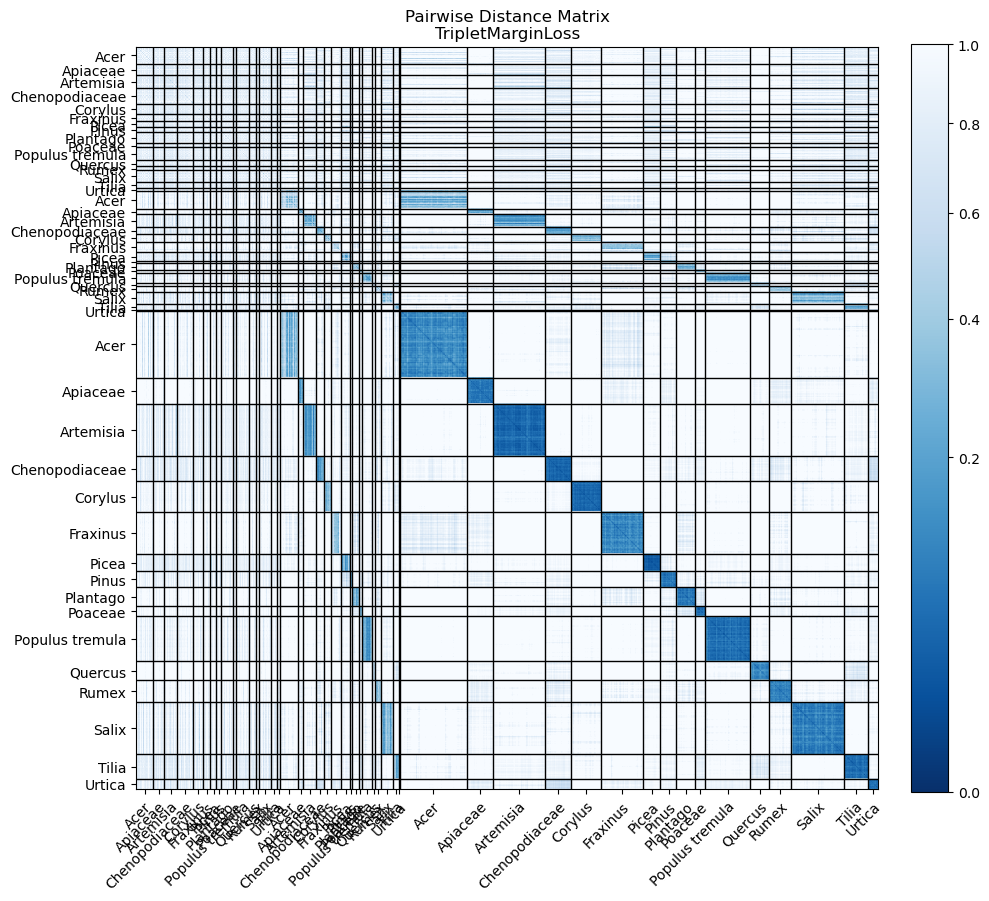

In [56]:
plot_matrix(embeddings_data, labels_data_str, 'TripletMarginLoss')

In [57]:
def plot_tsne(embeddings_data, labels_data_str, subtitle: str = None):
    class_to_indices = {c: [] for c in np.unique(labels_data_str)}
    for i, label in enumerate(labels_data_str):
        class_to_indices[label].append(i)
    vectors = np.array(embeddings_data)
    colors = matplotlib.colormaps['tab20'].colors
    
    labels = [""] * vectors.shape[0]
    print(len(labels))
    for class_name, indices in class_to_indices.items():
        for index in indices:
            labels[index] = class_name
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, metric="cosine", n_iter=2000, n_jobs=-1, early_exaggeration=12)
    vectors_2d = tsne.fit_transform(vectors)
    
    plt.figure(figsize=(8, 6))
    for i, (class_name, indices) in enumerate(class_to_indices.items()):
        mask = np.isin(range(vectors.shape[0]), indices)
        plt.scatter(vectors_2d[mask, 0], vectors_2d[mask, 1], 
                    label=class_name, color=colors[i], alpha=0.6)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    if subtitle: 
        plt.title("t-SNE visualization of image features\n"+subtitle)
    else:
        plt.title("t-SNE visualization of image features")
    plt.tight_layout()
    plt.show()

445


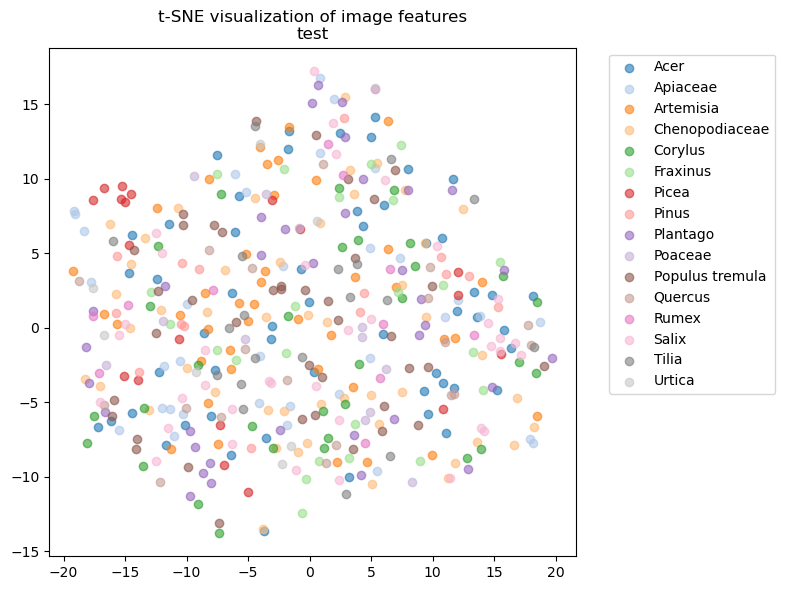

370


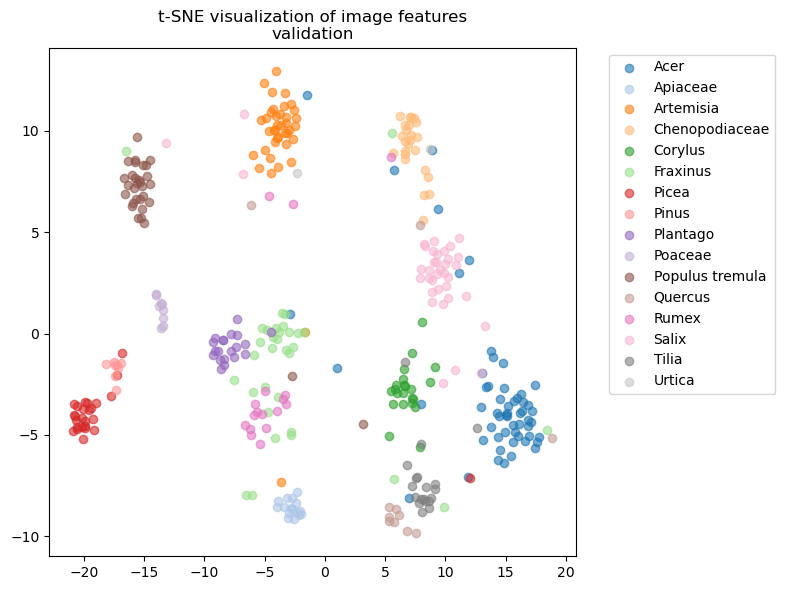

1478


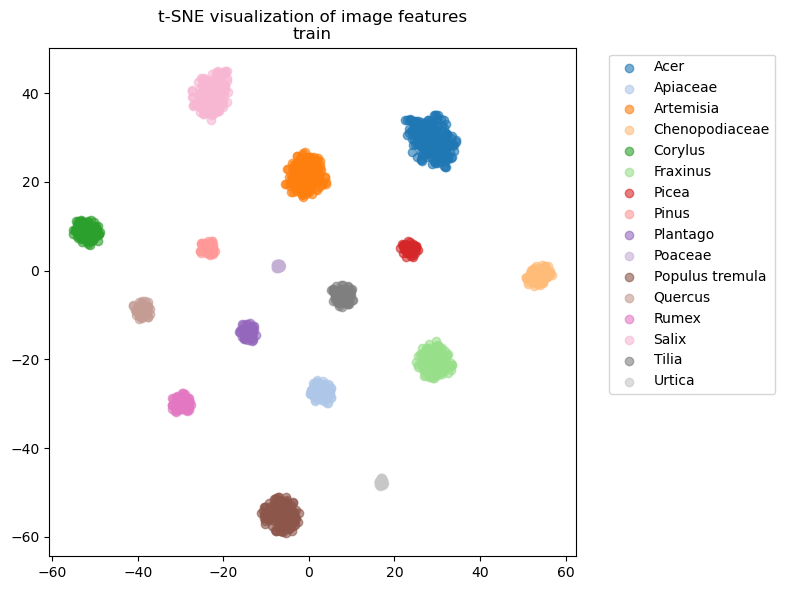

2293


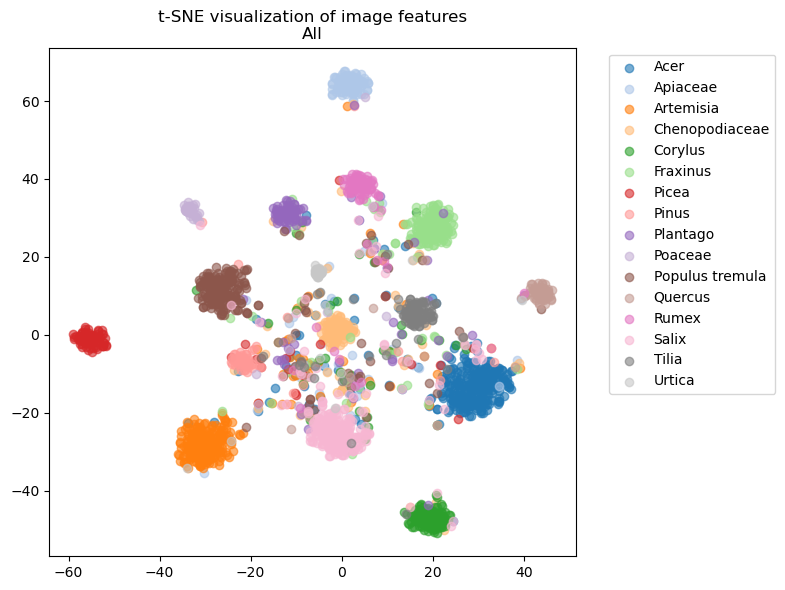

In [58]:
import itertools
titles = ["test", "validation", "train", "All"]
for i, dataset in enumerate(embeddings_data + [np.vstack(embeddings_data), ]):
    plot_tsne(dataset, 
              (labels_data_str + [list(itertools.chain.from_iterable(labels_data_str)),])[i], 
              titles[i])